[![IJsselsteinloop](data/IJsselsteinloop.jpeg)](https://www.ijsselsteinloop.nl)

## Imports

In [1]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import geopandas as gpd
from bs4 import BeautifulSoup
from tqdm import tqdm
from pathlib import Path

In [2]:
import IJsselsteinloop

## Settings

In [3]:
# jaar
jaar = 2019

In [4]:
# color palette
colpal = {'Damesklassement':'#ff0080', 'Herenklassement':'#3498db'}

In [5]:
# distances
afstanden = {'5 km':5.000, '10 km':10.000, '21.1 km':21.0975}

## Data Prepatation

In [6]:
# ophalen data
uitslagen = IJsselsteinloop.ophalen_data(jaar)

In [7]:
# opschonen data
uitslagen = IJsselsteinloop.namen(uitslagen)
uitslagen = IJsselsteinloop.woonplaatsen(uitslagen)
uitslagen = IJsselsteinloop.nettotijd(uitslagen)

In [8]:
# verrijken data
uitslagen = IJsselsteinloop.gemeenten(uitslagen)
uitslagen = IJsselsteinloop.nettotijd_sec(uitslagen)

In [9]:
# typeren data
uitslagen['afstand'] = pd.Categorical(uitslagen.afstand,
                                      ['5 km', '10 km', '21.1 km'],
                                      ordered=True)

In [10]:
# tonen data
uitslagen.iloc[:, uitslagen.columns != 'naam'].sample(n=7)

,nettotijd,klassement,startnummer,woonplaats,jaar,afstand,gemeente,tot_ijsselstein,nettotijd_sec
24110,00:49:07,Herenklassement,292,Nieuwegein,2018,10 km,Nieuwegein,4.53,2947
11624,02:01:57,Herenklassement,7069,Nijmegen,2012,21.1 km,Nijmegen,59.42,7317
10995,00:57:47,Herenklassement,6011,Volkel,2012,10 km,Uden,59.65,3467
11763,00:26:23,Damesklassement,3381,IJsselstein,2012,5 km,IJsselstein,0.00,1583
23756,00:59:02,Damesklassement,1289,IJsselstein,2018,10 km,IJsselstein,0.00,3542
23422,00:26:58,Herenklassement,3160,Maastricht,2017,5 km,Maastricht,138.76,1618
5887,00:40:40,Herenklassement,796,Woudenberg,2010,10 km,Woudenberg,27.93,2440


## Data Visualization (laatste jaar)

### Verdeling deelnemers per afstand

In [11]:
# data preparation
df = uitslagen[uitslagen.jaar == jaar].copy()
df['klassement'] = ['Heren' if k == 'Herenklassement' else 'Dames' for k in df.klassement]
df['afstand'] = pd.Categorical(df.afstand, ['5 km', '10 km', '21.1 km'], ordered=True)

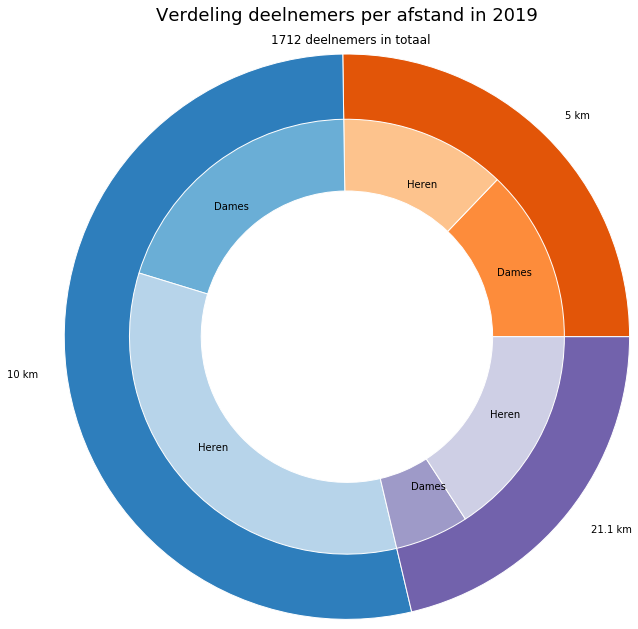

In [12]:
# groups an subgroups
group_names = df.afstand.dtype.categories
group_size = df.groupby(by='afstand').size()
subgroup_names = df.groupby(by=['afstand', 'klassement']).size().reset_index().klassement
subgroup_size = df.groupby(by=['afstand', 'klassement']).size()
 
# colors
vk, tk, hm = [plt.cm.Oranges, plt.cm.Blues, plt.cm.Purples]
 
# first ring (outside)
fig, ax = plt.subplots(figsize=(10, 10))
ax.axis('equal')
mypie, _ = ax.pie(group_size, radius=1.3, labels=group_names, colors=[vk(0.7), tk(0.7), hm(0.7)])
plt.setp(mypie, width=0.33, edgecolor='white')
 
# second ring (inside)
mypie2, _ = ax.pie(subgroup_size, radius=1.3-0.3, labels=subgroup_names, labeldistance=0.75,
                   colors=[vk(0.5), vk(0.3), tk(0.5), tk(0.3), hm(0.5), hm(0.3)])
plt.setp(mypie2, width=0.33, edgecolor='white')
#plt.margins(60, 0)

# title and position
plt.title(f'Verdeling deelnemers per afstand in {jaar}', fontsize=18)
ax.title.set_position([0.5, 1.07])

# subtitle
ax.text(-0.35, 1.35, f'{df.shape[0]} deelnemers in totaal', fontsize=12)
 
# show plot
plt.show()

### Aantal deelnemers per gemeente

In [13]:
# read shapefile
kaart = gpd.read_file('data/2019_gemeentegrenzen_kustlijn.gpkg')

In [14]:
# participants per municipality
aantal = uitslagen[uitslagen.jaar == jaar].groupby(by=['gemeente']).size()\
.to_frame('aantal').reset_index()

In [15]:
# add data to map
df = pd.merge(kaart, aantal, how='left', left_on='gemeentenaam', right_on='gemeente')
df.drop(['gemeente'], axis=1, inplace=True)
df.aantal.fillna(0, inplace=True)
df['aantal'] = df.aantal.astype(int)

In [16]:
# set categories
indeling = [5, 10, 15, 20, 25, 50, 100, 250, 500, 1000]

In [17]:
# add category column
df['categorie'] = df.aantal.apply(lambda x: IJsselsteinloop.category(x, indeling))

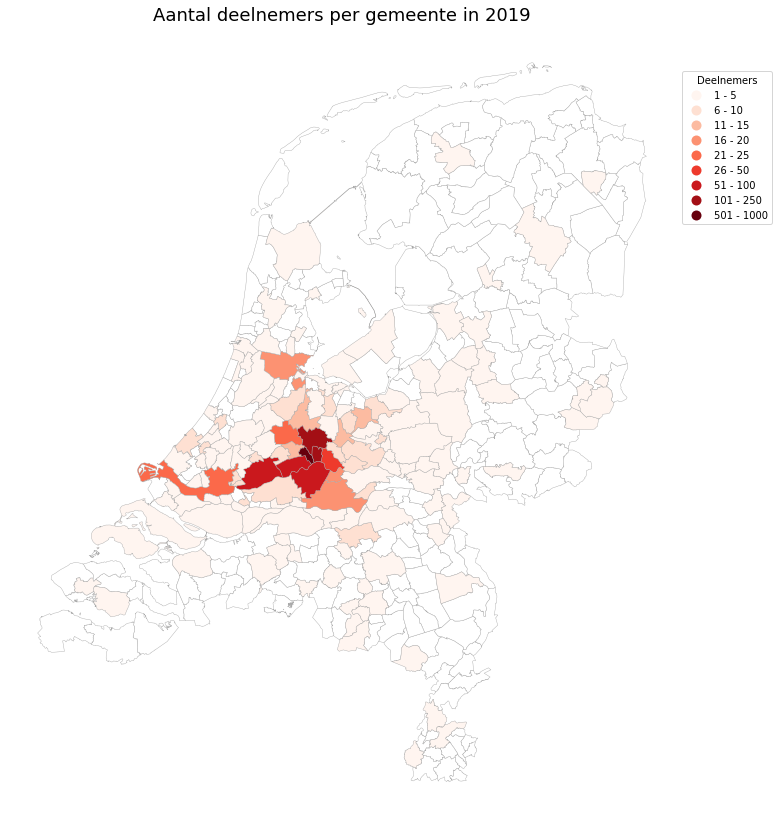

In [18]:
# show map
f, ax = plt.subplots(figsize=(12, 15))
df[df.aantal == 0].plot(ax=ax, color='white', edgecolor='darkgrey', linewidth=0.4)
df[df.aantal != 0].plot(ax=ax, column='categorie', categorical=True, cmap='Reds',
                        legend=True, edgecolor='darkgrey', linewidth=0.4)

plt.title(f'Aantal deelnemers per gemeente in {jaar}', fontsize=18)

labels = IJsselsteinloop.category_labels(indeling)
IJsselsteinloop.replace_legend_items(ax.get_legend(), labels)

legend = ax.get_legend()
legend.get_frame().set_alpha(0.8)
legend.set_bbox_to_anchor((1.15, -0.05, 0, 1))
legend.set_title('Deelnemers')

plt.axis('off')
plt.savefig('data/deelnemers_2019.png')
plt.show()

### Reisafstand deelnemers naar IJsselstein

In [19]:
# data preparation
df = uitslagen[uitslagen.jaar == jaar]

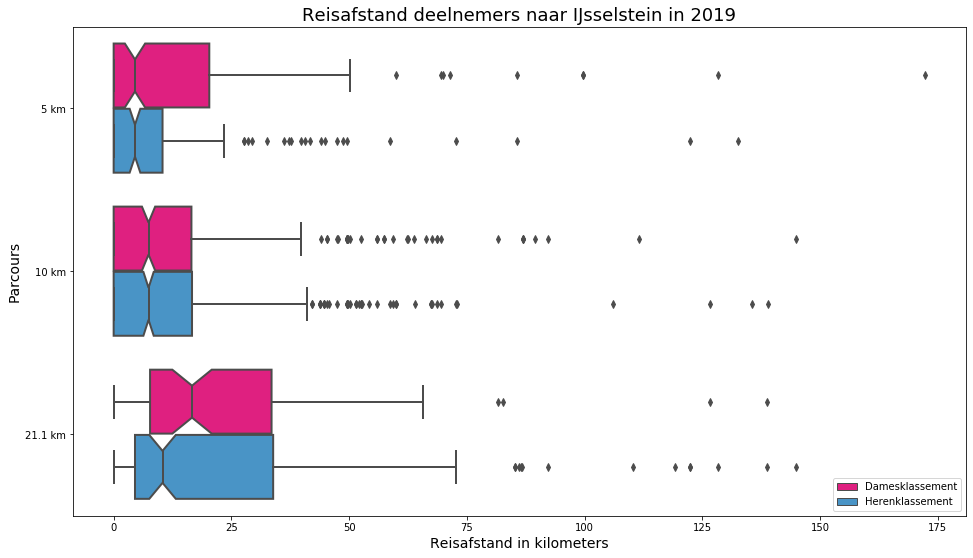

In [20]:
# boxplot
fig, ax = plt.subplots(figsize=(16, 9))
ax = sns.boxplot(data=df, x='tot_ijsselstein', y='afstand',
                 hue='klassement', hue_order=colpal.keys(), palette=colpal.values(),
                 notch=True, linewidth=2)
ax.legend(loc='lower right')
plt.title(f'Reisafstand deelnemers naar IJsselstein in {jaar}', fontsize=18)
plt.xlabel('Reisafstand in kilometers', fontsize=14)
plt.ylabel('Parcours', fontsize=14)
plt.show()

### Top 10 plaatsen op basis van aantal deelnemers

In [21]:
# data preparation
df = uitslagen[uitslagen.jaar == jaar].copy()
df.drop(df[df.woonplaats.isna()].index, axis=0, inplace=True)
df = df.groupby(by=['woonplaats']).size().to_frame('aantal').reset_index()\
.sort_values(by=['aantal'], ascending=False)
df = df.head(10)

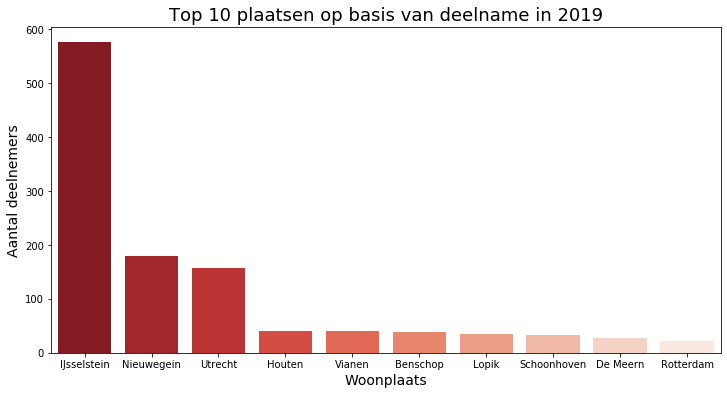

In [22]:
# data visualization
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(ax=ax, data=df, x='woonplaats', y='aantal', palette=sns.color_palette('Reds_r', 10))
plt.title(f'Top 10 plaatsen op basis van deelname in {jaar}', fontsize=18)
plt.xlabel('Woonplaats', fontsize=14)
plt.ylabel('Aantal deelnemers', fontsize=14)
plt.show()

### Aantal deelnemers per afstand

In [23]:
# preprocess data
df = uitslagen[uitslagen.jaar == jaar].groupby(by=['afstand', 'klassement']).size()\
.to_frame('aantal').reset_index()

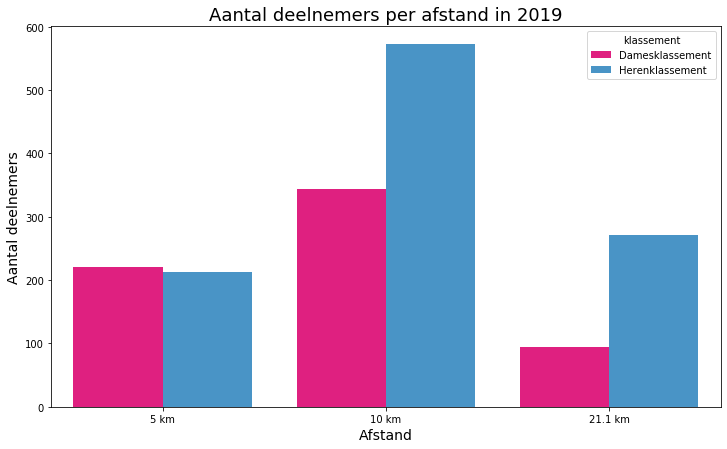

In [24]:
# visualize data
fig, ax = plt.subplots(figsize=(12, 7))
sns.barplot(ax=ax, data=df,
            x='afstand', y='aantal',
            hue='klassement', hue_order=colpal.keys(), palette=colpal.values(),
            order=['5 km', '10 km', '21.1 km'])
plt.title(f'Aantal deelnemers per afstand in {jaar}', fontsize=18)
plt.xlabel('Afstand', fontsize=14)
plt.ylabel('Aantal deelnemers', fontsize=14)
plt.show()

### Uitslagen per afstand

In [25]:
# preprocess data
df = uitslagen[uitslagen.jaar == jaar]

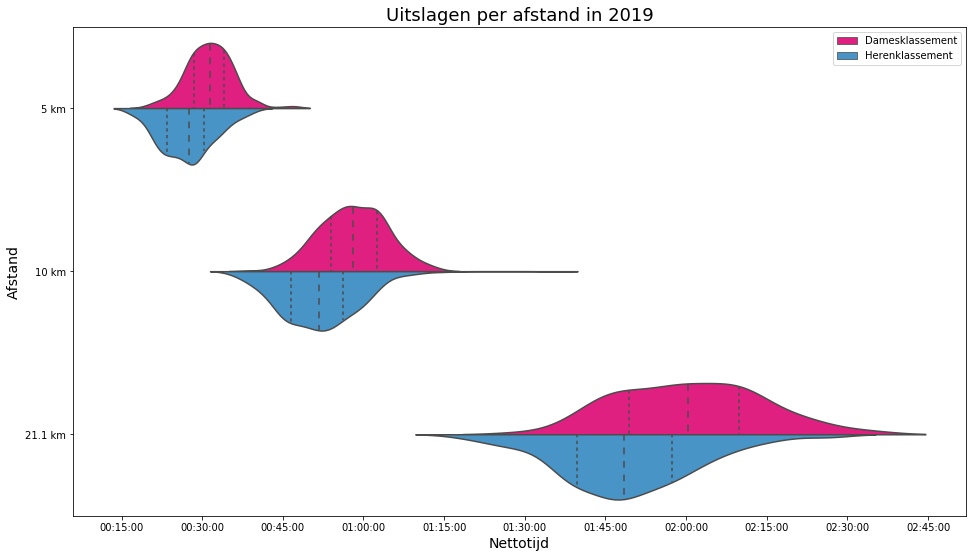

In [26]:
# violinplot
fig, ax = plt.subplots(figsize=(16, 9))
sns.violinplot(ax=ax, data=df, x='nettotijd_sec', y='afstand', order=['5 km', '10 km', '21.1 km'],
               hue='klassement', hue_order=colpal.keys(),  palette=colpal.values(),
               split=True, orient='h', inner='quartiles')

# set tick distance in minutes
tick_distance = 15

# set min and max ticks
x_min = (min(df.nettotijd_sec) // (tick_distance * 60)) * (tick_distance * 60)
x_max = (max(df.nettotijd_sec) // (tick_distance * 60)) * ((tick_distance + 2) * 60)
step = tick_distance * 60

# set new ticks
plt.xticks(np.arange(x_min, x_max, step))

# get the ticks
ticks = ax.get_xticks()

# convert ticks to time strings
ax.set_xticklabels(pd.to_datetime(ticks, unit='s').strftime('%H:%M:%S'))

# set title and axis labels
plt.title(f'Uitslagen per afstand in {jaar}', fontsize=18)
plt.xlabel('Nettotijd', fontsize=14)
plt.ylabel('Afstand', fontsize=14)

# location legend
ax.legend(loc='best')

# show plot
plt.show()

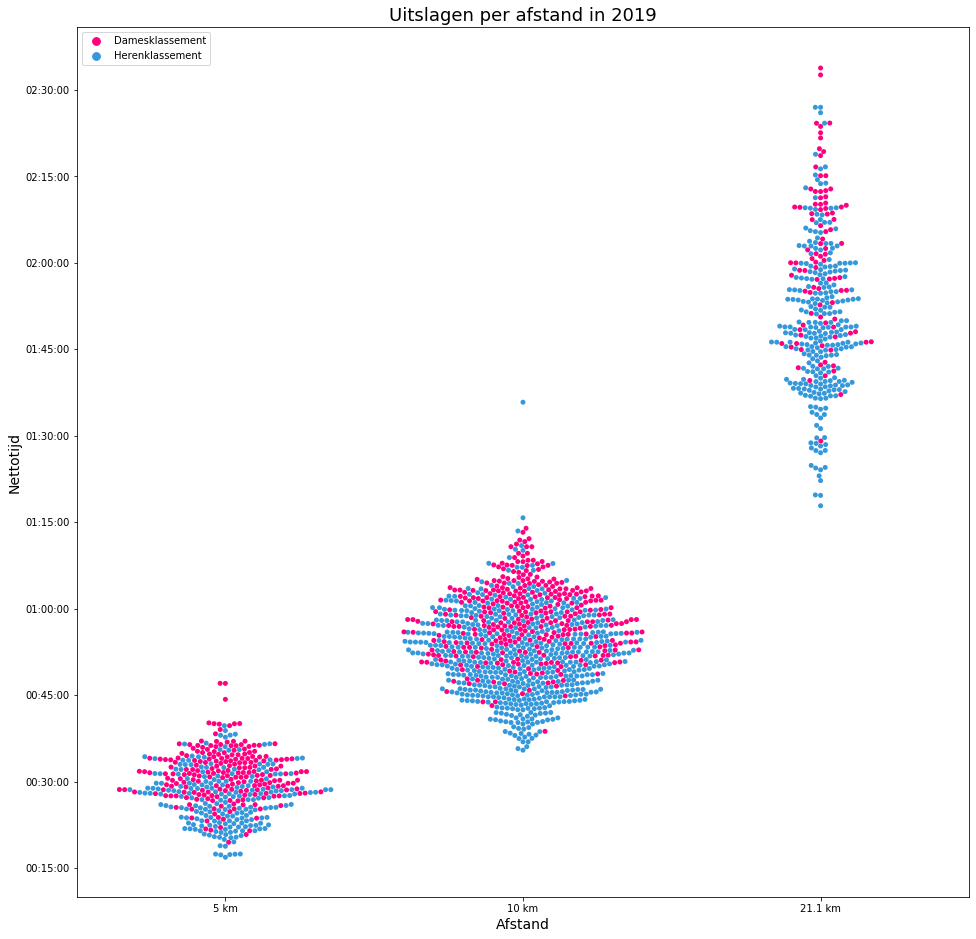

In [27]:
# swarmplot
fig, ax = plt.subplots(figsize=(16, 16))
sns.swarmplot(ax=ax, data=df, x='afstand', y='nettotijd_sec',
              order=['5 km', '10 km', '21.1 km'],
              hue='klassement',
              hue_order=colpal.keys(),
              palette=colpal.values())

# set tick distance in minutes
tick_distance = 15

# set min and max ticks
y_min = (min(df.nettotijd_sec) // (tick_distance * 60)) * (tick_distance * 60)
y_max = (max(df.nettotijd_sec) // (tick_distance * 60)) * ((tick_distance + 1) * 60)
step = tick_distance * 60

# set new ticks
plt.yticks(np.arange(y_min, y_max, step))

# get the ticks
ticks = ax.get_yticks()

# convert ticks to time strings
ax.set_yticklabels(pd.to_datetime(ticks, unit='s').strftime('%H:%M:%S'))

# set title and axis labels
plt.title(f'Uitslagen per afstand in {jaar}', fontsize=18)
plt.xlabel('Afstand', fontsize=14)
plt.ylabel('Nettotijd', fontsize=14)

# location legend
ax.legend(loc='upper left')

# show plot
plt.show()

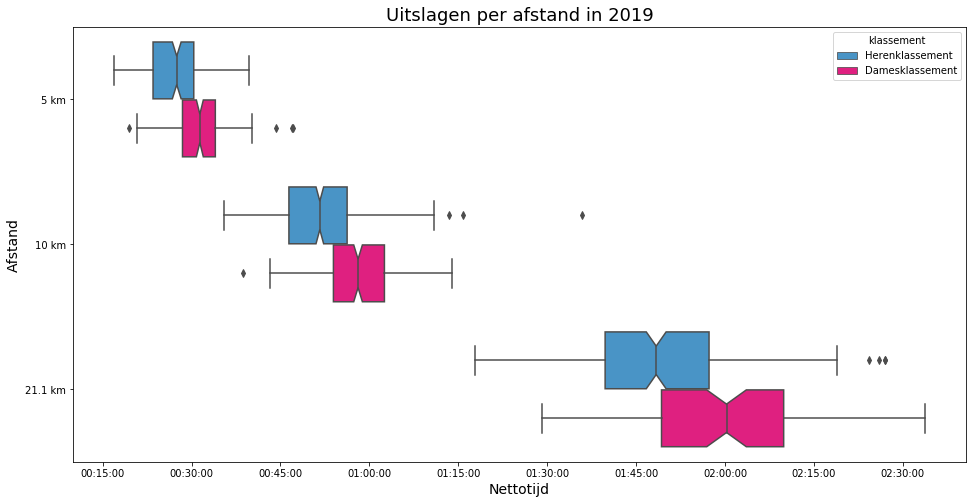

In [28]:
# boxplot
fig, ax = plt.subplots(figsize=(16, 8))
sns.boxplot(ax=ax, data=df, x='nettotijd_sec', y='afstand',
            order=['5 km', '10 km', '21.1 km'],
            hue='klassement',
            hue_order=['Herenklassement', 'Damesklassement'],
            palette=[colpal['Herenklassement'], colpal['Damesklassement']],
            linewidth=1.5,
            notch=True,
            orient='h')

# set tick distance in minutes
tick_distance = 15

# set min and max ticks
x_min = (min(df.nettotijd_sec) // (tick_distance * 60)) * (tick_distance * 60)
x_max = (max(df.nettotijd_sec) // (tick_distance * 60)) * ((tick_distance + 1) * 60)
step = tick_distance * 60

# set new ticks
plt.xticks(np.arange(x_min, x_max, step))

# get the ticks
ticks = ax.get_xticks()

# convert ticks to time strings
ax.set_xticklabels(pd.to_datetime(ticks, unit='s').strftime('%H:%M:%S'))

# set title and axis labels
plt.title(f'Uitslagen per afstand in {jaar}', fontsize=18)
plt.xlabel('Nettotijd', fontsize=14)
plt.ylabel('Afstand', fontsize=14)

# show plot
plt.show()

## Hoogste tempo (pace) per gemeente

In [29]:
# set distance
afstand = '21.1 km' # choose 5, 10 or 21.1

In [30]:
# preprocess data (fastest time per distance and municipality)
aantal = uitslagen.loc[uitslagen.jaar == jaar, ['gemeente', 'afstand', 'nettotijd_sec']]\
.groupby(by=['gemeente', 'afstand']).min().reset_index()
aantal.nettotijd_sec.fillna(0, inplace=True)
aantal['nettotijd_sec'] = aantal.nettotijd_sec.astype(int)

In [31]:
# add data to map
df = pd.merge(kaart, aantal[aantal.afstand == afstand], how='left',
              left_on='gemeentenaam', right_on='gemeente')
df.drop(['afstand'], axis=1, inplace=True)
df.nettotijd_sec.fillna(0, inplace=True)
df['nettotijd_sec'] = df.nettotijd_sec.astype(int)
df['pace_sec'] = df.nettotijd_sec / afstanden[afstand]
df['pace'] = df.pace_sec.apply(lambda x: pd.to_datetime(x, unit='s').strftime('%H:%M:%S'))

In [32]:
# set categories
step_sec = 15 # number of seconds per step
pace_sec_min = ((df[df.nettotijd_sec != 0].nettotijd_sec.min()\
                 / afstanden[afstand]) // step_sec) * step_sec
pace_sec_max = (((df[df.nettotijd_sec != 0].nettotijd_sec.max()\
                  / afstanden[afstand]) // step_sec) + 1) * step_sec + 1

indeling = np.arange(pace_sec_min, pace_sec_max, step_sec)

In [33]:
# add category column
df['categorie'] = df.pace_sec.apply(lambda x: IJsselsteinloop.category(x, indeling))

In [34]:
# set labels
labels = dict()
for i in indeling:
    labels[i] = '≤ {}'.format(pd.to_datetime(i, unit='s').strftime('%H:%M:%S'))

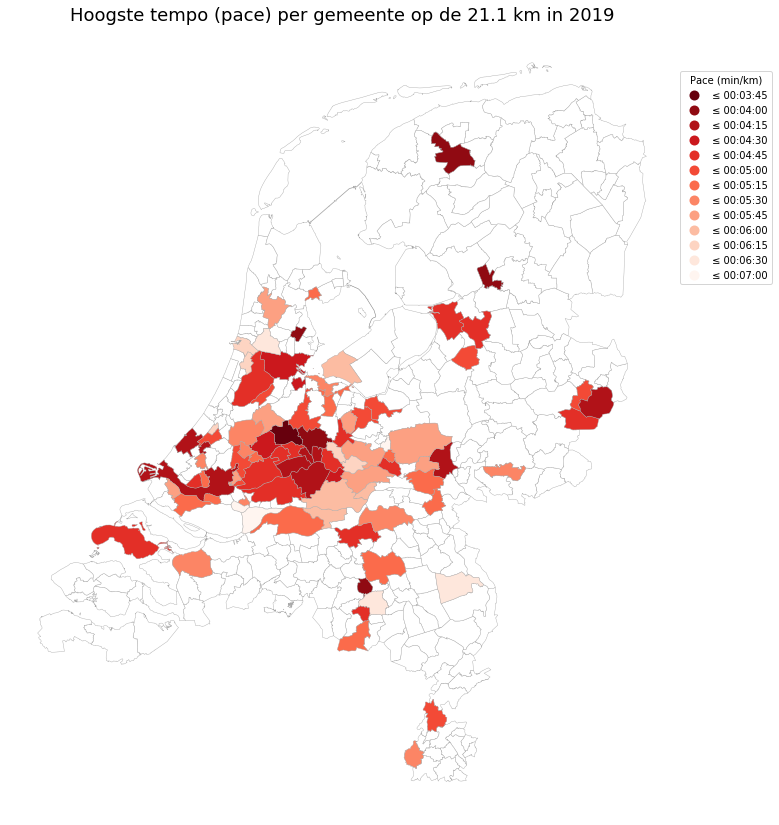

In [35]:
# show map
f, ax = plt.subplots(figsize=(12, 15))
df[df.nettotijd_sec == 0].plot(ax=ax, color='white', edgecolor='darkgrey', linewidth=0.4)
df[df.nettotijd_sec != 0].plot(ax=ax, column='categorie', categorical=True, cmap='Reds_r',
                               legend=True, edgecolor='darkgrey', linewidth=0.4)

IJsselsteinloop.replace_legend_items(ax.get_legend(), labels)

plt.title(f'Hoogste tempo (pace) per gemeente op de {afstand} in {jaar}', fontsize=18)

legend = ax.get_legend()
legend.get_frame().set_alpha(0.8)
legend.set_bbox_to_anchor((1.15, -0.05, 0, 1))
legend.set_title('Pace (min/km)')

plt.axis('off')
plt.show()

## Data Visualization (alle jaren)

### Totaal aantal deelnemers per gemeente 

In [36]:
# participant count per municipality
aantal = uitslagen.groupby(by=['gemeente']).size().to_frame('aantal').reset_index()

In [37]:
# add data to map
df = pd.merge(kaart, aantal, how='left', left_on='gemeentenaam', right_on='gemeente')
df.drop(['gemeente'], axis=1, inplace=True)
df.aantal.fillna(0, inplace=True)
df['aantal'] = df.aantal.astype(int)

In [38]:
# set categories
indeling = [10, 25, 50, 75, 100, 200, 500, 1000, 5000, 10000]

In [39]:
# add category columns
df['categorie'] = df.aantal.apply(lambda x: IJsselsteinloop.category(x, indeling))

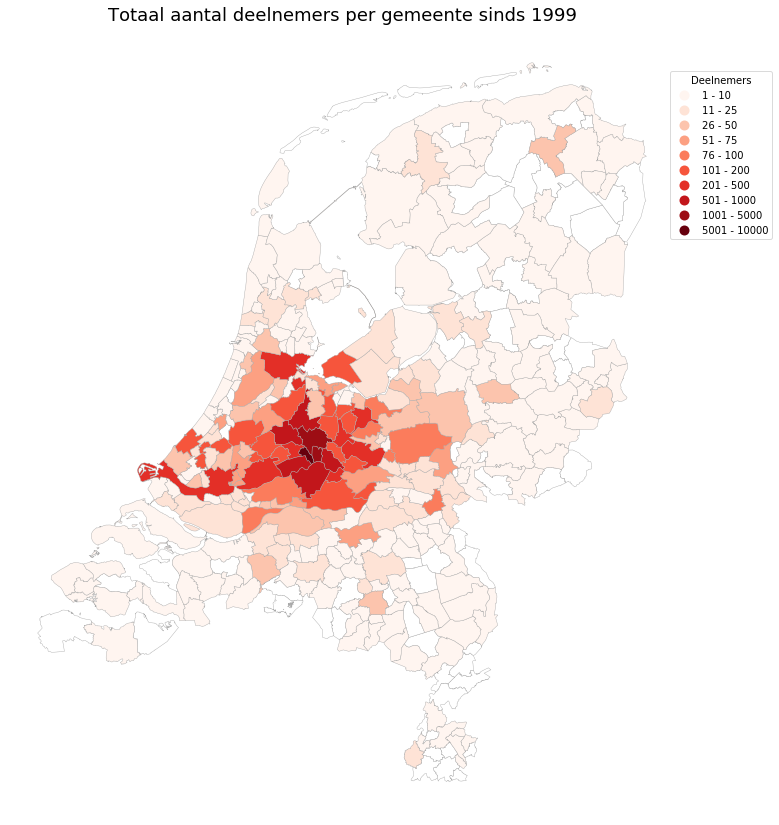

In [40]:
# show map
f, ax = plt.subplots(figsize=(12, 15))
df[df.aantal == 0].plot(ax=ax, color='white', edgecolor='darkgrey', linewidth=0.4)
df[df.aantal != 0].plot(ax=ax, column='categorie', categorical=True, cmap='Reds',
                        legend=True, edgecolor='darkgrey', linewidth=0.4)

plt.title(f'Totaal aantal deelnemers per gemeente sinds {uitslagen.jaar.min()}', fontsize=18)

labels = IJsselsteinloop.category_labels(indeling)
IJsselsteinloop.replace_legend_items(ax.get_legend(), labels)

legend = ax.get_legend()
legend.get_frame().set_alpha(0.7)
legend.set_bbox_to_anchor((1.15, -0.05, 0, 1))
legend.set_title('Deelnemers')

plt.axis('off')
plt.show()

### Aantal deelnemers per afstand

In [41]:
# data preparation
df = uitslagen.groupby(by=['jaar', 'afstand']).size().to_frame('aantal').reset_index()

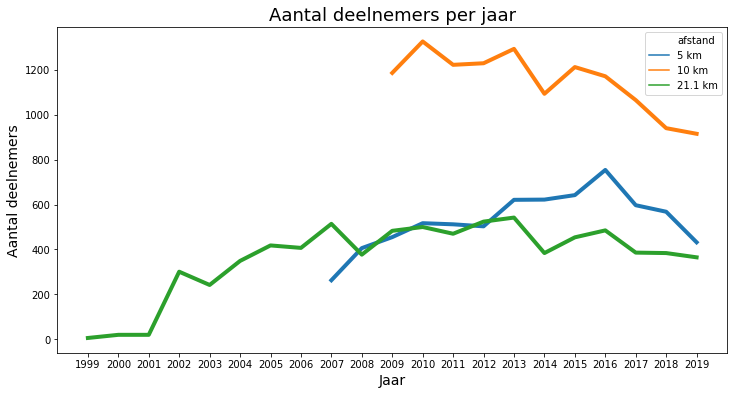

In [42]:
# data visualization
fig, ax = plt.subplots(figsize=(12, 6))
sns.lineplot(ax=ax, data=df[df.aantal > 0], x='jaar', y='aantal', hue='afstand', markers=True,
             linewidth=4, hue_order=df.afstand.dtype.categories)
plt.xticks(df.jaar.unique()) # show each year as a seperate tick
plt.title('Aantal deelnemers per jaar', fontsize=18)
plt.xlabel('Jaar', fontsize=14)
plt.ylabel('Aantal deelnemers', fontsize=14)
plt.show()

### Aantal deelnemers per afstand en klassement

In [43]:
# data preparation
df = uitslagen.groupby(by=['jaar', 'afstand', 'klassement']).size()\
.to_frame('aantal').reset_index()

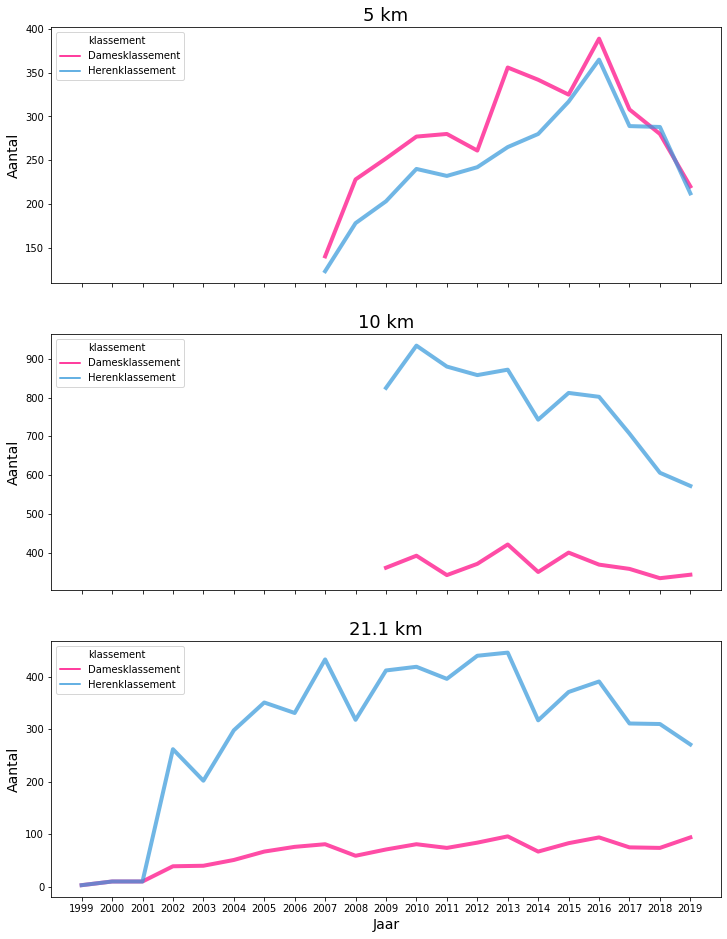

In [44]:
# data visualization
f, ax = plt.subplots(nrows=3, figsize=(12, 16), sharex=True, sharey=False)
for index, value in enumerate(df.afstand.dtype.categories):
    sns.lineplot(ax=ax[index], x='jaar', y='aantal',
                 hue='klassement', hue_order=colpal.keys(), palette=colpal.values(),
                 linewidth=4, alpha=0.7,
                 data=df[(df.afstand==value) & (df.aantal > 0)])
    ax[index].set_xticks(df.jaar.unique())
    ax[index].set_title(value, fontsize=18)
    ax[index].set_xlabel('Jaar', fontsize=14)
    ax[index].set_ylabel('Aantal', fontsize=14)
    ax[index].legend(loc='upper left')
plt.show()

### Deelname per jaar voor de woonplaatsen met de meeste deelnemers

In [45]:
# set number of places in top x
top_x = 3

In [46]:
# places sorted descending by total number of participants 
top = uitslagen.groupby(by=['woonplaats']).size().sort_values(ascending=False).index[:top_x]

In [47]:
# select data from top x
df = uitslagen[uitslagen.woonplaats.isin(top)].groupby(by=['jaar', 'woonplaats']).size()\
.to_frame('aantal').reset_index()

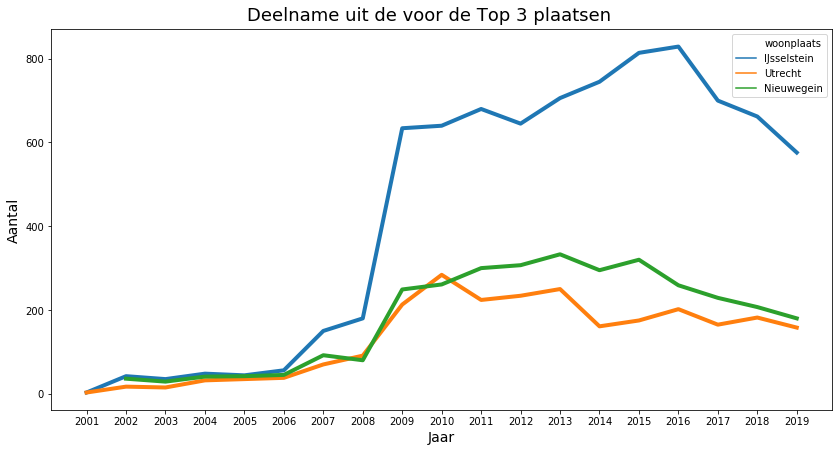

In [48]:
# data visualization
f, ax = plt.subplots(figsize=(14, 7))
f.suptitle(f'Deelname uit de voor de Top {top_x} plaatsen', fontsize=18, y=0.925)
ax = sns.lineplot(x='jaar', y='aantal', hue='woonplaats', linewidth=4, data=df)
ax.set_xticks(df.jaar.unique())
ax.set_xlabel('Jaar', fontsize=14)
ax.set_ylabel('Aantal', fontsize=14)
plt.show()

### Looptijden per afstand

In [49]:
# data preparation
df = uitslagen

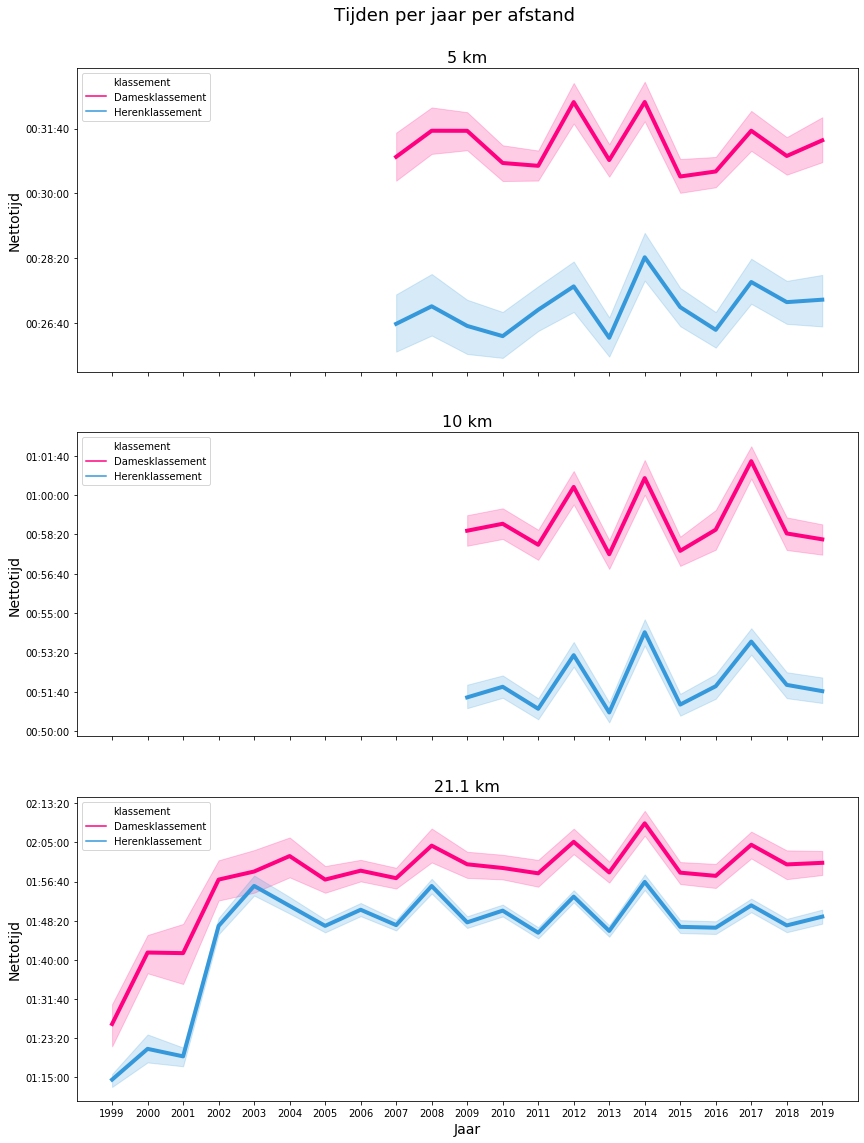

In [50]:
# data visualization
f, ax = plt.subplots(nrows=3, ncols=1, figsize=(14, 19), sharex=True, sharey=False)
f.suptitle('Tijden per jaar per afstand', fontsize=18, y=0.925)
plt.xticks(df.jaar.unique())
for index, value in enumerate(df.afstand.dtype.categories):
    data = df[df.afstand == value]
    sns.lineplot(ax=ax[index], x='jaar', y='nettotijd_sec', hue='klassement',
                 hue_order=colpal.keys(), palette=colpal.values(), linewidth=4, data=data)
    ax[index].set_title(value, fontsize=16)
    ax[index].set_xticklabels(df.jaar.unique())
    ax[index].set_xlabel('Jaar', fontsize=14)
    ticks = ax[index].get_yticks() # get the ticks
    ax[index].set_yticklabels(pd.to_datetime(ticks, unit='s')\
                              .strftime('%H:%M:%S')) # convert ticks to time strings
    ax[index].set_ylabel('Nettotijd', fontsize=14)
    ax[index].legend(loc='upper left')

plt.show()

### Looptijden 21.1 km t.o.v. gemiddelde temperatuur

In [51]:
# ophalen weer
if not Path(f'data/weer_1999_{jaar}.csv').is_file():
    IJsselsteinloop.ophalen_weer(1999, jaar)

weer = pd.read_csv(f'data/weer_1999_{jaar}.csv')

In [52]:
df = uitslagen[uitslagen.afstand == '21.1 km'].groupby(by='jaar').nettotijd_sec.mean()\
.to_frame('gem_tijd')
df['gem_temperatuur'] = weer.temperatuur.values

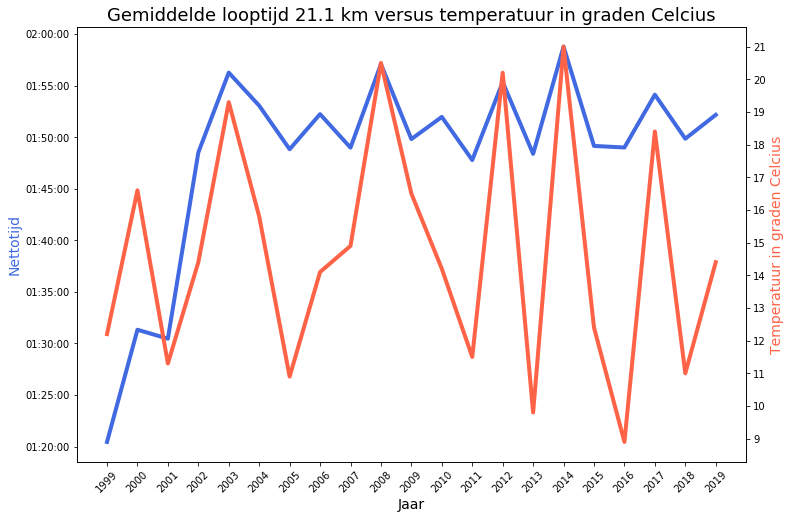

In [53]:
fig, ax1 = plt.subplots(figsize=(12, 8))
ax2 = ax1.twinx()
ax1.plot(df.index, df.gem_tijd, c='Royalblue', linewidth=4)
ax2.plot(df.index, df.gem_temperatuur, c='tomato', linewidth=4)

plt.title('Gemiddelde looptijd 21.1 km versus temperatuur in graden Celcius', fontsize=18)

plt.xticks(df.index)
ax1.set_xticklabels(df.index, rotation=45)
ax1.set_xlabel('Jaar', fontsize=14)

y1ticks = list(range(int(df.gem_tijd.min() // 300 * 300),
                     int((df.gem_tijd.max() // 300 + 2) * 300),
                     300))
ax1.set_yticks(y1ticks)
ax1.set_yticklabels(pd.to_datetime(y1ticks, unit='s')\
                    .strftime('%H:%M:%S')) # convert ticks to time strings
ax1.set_ylabel('Nettotijd', color='Royalblue', fontsize=14)

y2ticks = list(range(int(round(df.gem_temperatuur.min(), 0)),
                     int(round(df.gem_temperatuur.max(), 0)) + 1))
ax2.set_yticks(y2ticks)
ax2.set_ylabel('Temperatuur in graden Celcius', color='tomato', fontsize=14)


plt.show()

### Gemiddelde reisafstand deelnemers

In [54]:
# data preparation
df = uitslagen.copy()
df = df.groupby(by=['jaar', 'afstand']).tot_ijsselstein.mean().to_frame('aantal').reset_index()
df.dropna(inplace=True)

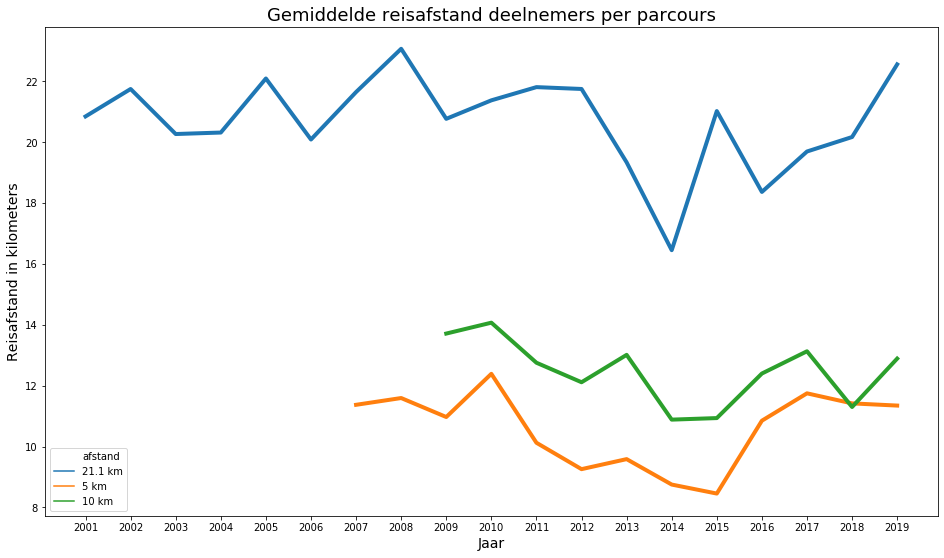

In [55]:
# data visualization
f, ax = plt.subplots(figsize=(16, 9))
ax = sns.lineplot(x='jaar', y='aantal', hue='afstand', linewidth=4, data=df)
ax.set_xticks(df.jaar.unique())
ax.set_title('Gemiddelde reisafstand deelnemers per parcours', fontsize=18)
ax.set_xlabel('Jaar', fontsize=14)
ax.set_ylabel('Reisafstand in kilometers', fontsize=14)
plt.show()

### Heatmap deelnemers per afstand

In [56]:
# data preparation
df = uitslagen.groupby(by=['jaar', 'afstand']).size().to_frame('aantal').reset_index()
pv = df.pivot('afstand', 'jaar', 'aantal')

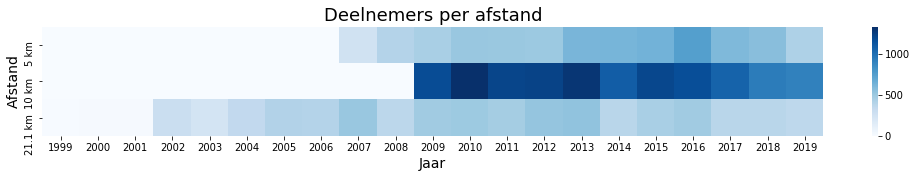

In [57]:
# data visualization
f, ax = plt.subplots(figsize=(17.5, 2))
ax = sns.heatmap(pv, cmap='Blues')
ax.set_title('Deelnemers per afstand', fontsize=18)
ax.set_xlabel('Jaar', fontsize=14)
ax.set_ylabel('Afstand', fontsize=14)
plt.show()

### Heatmap deelnemers per klassementen

In [58]:
# data preparation
df = uitslagen.groupby(by=['jaar', 'klassement']).size().to_frame('aantal').reset_index()
pv = df.pivot('klassement', 'jaar', 'aantal')

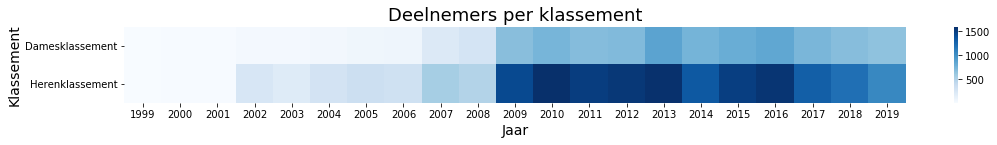

In [59]:
# data visualization
f, ax = plt.subplots(figsize=(17.5, 1.4))
ax = sns.heatmap(pv, cmap='Blues')
ax.set_title('Deelnemers per klassement', fontsize=18)
ax.set_xlabel('Jaar', fontsize=14)
ax.set_ylabel('Klassement', fontsize=14)
plt.show()

### Verdeling looptijden halve marathon (laatste 10 jaar)

In [60]:
# data preparation
df = uitslagen[(uitslagen.jaar > uitslagen.jaar.max() - 10)
               & (uitslagen.afstand == '21.1 km')].copy()

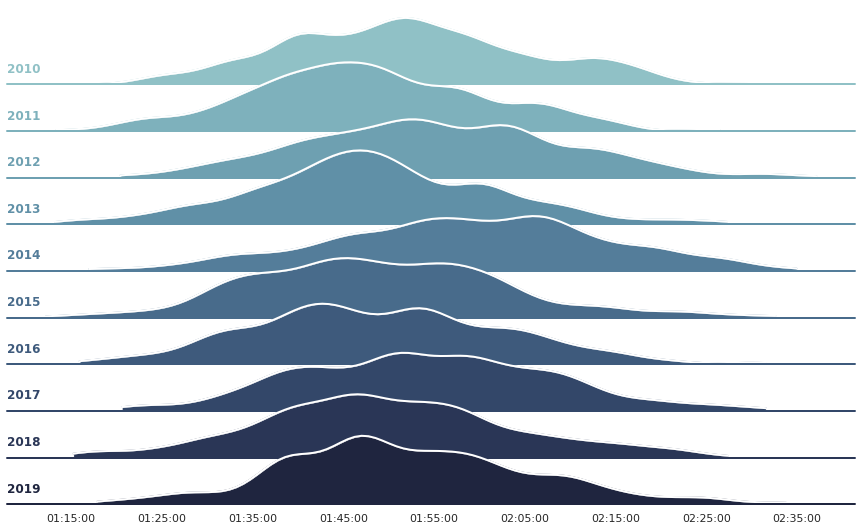

In [61]:
# data visualization
sns.set(style='white', rc={'axes.facecolor': (0, 0, 0, 0)})

# initialize the facetgrid object
pal = sns.cubehelix_palette(10, rot=-.25, light=.7)
g = sns.FacetGrid(df, row='jaar', hue='jaar', aspect=16, height=0.8, palette=pal)

xticks = np.array(range(4500, 9601, 600))
g.set(xticks=xticks)
g.set_xticklabels(pd.to_datetime(xticks, unit='s').strftime('%H:%M:%S'))

# draw the densities in a few steps
g.map(sns.kdeplot, 'nettotijd_sec', clip_on=False, shade=True, alpha=1, lw=1.5, bw=.2)
g.map(sns.kdeplot, 'nettotijd_sec', clip_on=False, color='w', lw=2, bw=.2)
g.map(plt.axhline, y=0, lw=2, clip_on=False)

# define and use a simple function to label the plot in axes coordinates
def label(jaar, color, label):
    ax = plt.gca()
    ax.text(0, .2, label, fontweight='bold', color=color,
            ha='left', va='center', transform=ax.transAxes)
g.map(label, 'nettotijd_sec')

# set the subplots to overlap
g.fig.subplots_adjust(hspace=-.4)

# remove axes details that don't play well with overlap
g.set_titles('')
g.set(yticks=[])
g.despine(bottom=True, left=True)
g.set(xlabel=None)

# show plot
plt.show()